In [85]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
import sqlite3
import scipy.stats as stats

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [5]:
DB = "..\\Data\\hockey_data_goalies.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

<h2>Determine the Prior Distribution</h2>

In [86]:
def season_finder(date):
    if date.month > 8:
        return date.year
    else:
        return date.year-1
 

#get player logs for the last 3 years

q = ("""SELECT * 
            FROM player_log 
        """)
games = run_query(q)
games['date_game'] = games['date_game'].astype('datetime64') #convert to datetime
games['time_on_ice'] = games['time_on_ice'].str.extract(r'(\d*)\:\d*')[0].astype(int)+games['time_on_ice'].str.extract(r'\d*\:(\d*)')[0].astype(int)/60
games['season'] = games['date_game'].map(lambda x: season_finder(x))
gamesgb = games.groupby(['player_id','season']).sum()
#remove players who've played less than 60 minutes in a season
gamesgb = gamesgb[gamesgb['time_on_ice']>120]
gamesgb['save_pct'] = gamesgb['saves']/gamesgb['shots_against']

In [87]:
gamesgb

age  goals_against  shots_against  saves  save_pct  \
player_id season                                                            
aebisda01 2000     596.737             52            538    486  0.903346   
          2001     502.045             37            538    501  0.931227   
          2002     547.925             50            593    543  0.915683   
          2003    1606.624            129           1703   1574  0.924251   
          2005    1395.353            149           1473   1324  0.898846   
...                    ...            ...            ...    ...       ...   
youngwe01 1993     275.792             20            211    191  0.905213   
          1994     316.442             27            255    228  0.894118   
zatkoje01 2013     532.254             51            582    531  0.912371   
          2015     399.760             34            408    374  0.916667   
          2016     383.468             27            223    196  0.878924   

                  shutouts  pen_min  time_on_ice  injured  
player_id season                                           
aebisda01 2000           3        0  1392.583333        0  
          2001           2        4  1183.500000        0  
          2002           1        4  1235.116667        0  
          2003           4        4  3702.816667        0  
          2005           3       16  2895.083333        0  
...                    ...      ...          ...      ...  
youngwe01 1993           1        4   479.700000        0  
          1994           0        2   496.633333        0  
zatkoje01 2013           1        0  1171.366667        0  
          2015           0        0   732.050000        0  
          2016           0        0   550.400000        1  

[2007 rows x 9 columns]

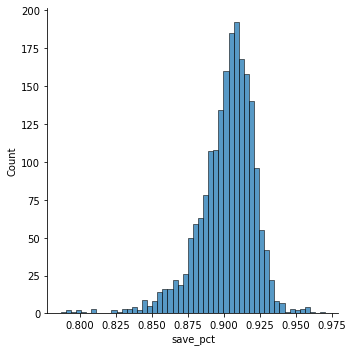

In [88]:
sns.displot(gamesgb['save_pct'])

plt.show()

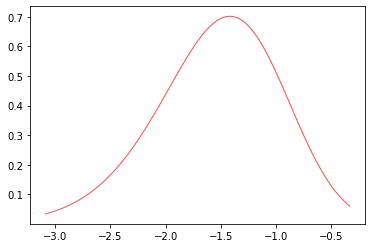

In [94]:
fig, ax = plt.subplots(1, 1)
c = 10
x = np.linspace(stats.powernorm.ppf(0.01, c),
                stats.powernorm.ppf(0.99, c), 100)
ax.plot(x, stats.powernorm.pdf(x, c),
       'r-', lw=1, alpha=0.7, label='powernorm pdf')